In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Analysis
import os
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
#import regionmask
import pickle
import scipy.stats as stats
import glob
#import Ngl
#import Nio 
# import metpy.calc as mpc
# from metpy.units import units


In [2]:
import warnings
warnings.filterwarnings('ignore')


## Read in data 

In [3]:
# Where the files are saved (locally):
# dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/NoMoments-SrfFluxAvg-useAndre-scmIOPlandSrfOff-zconst32p5/'
# camFile = dataDir+'FSCAM.T42_T42.arm97.clasp_useAndre_Zconst32p5_srfFluxAvg1_noMoments-64lev_startDay0531_ctsmHMG.cam.h0.2015-05-31-00000.nc'
# clmFile = dataDir+'FSCAM.T42_T42.arm97.clasp_useAndre_Zconst32p5_srfFluxAvg1_noMoments-64lev_startDay0531_ctsmHMG.clm2.h0.2015-05-31-00000.nc'

dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/SingleLandType/zconst_32p5/V2_noSrfPropertiesPrescribed/'
camFile = dataDir+'FSCAM.T42_T42.arm97.clasp_Andre_Zconst32_noMoments-64lev_startDay0531.SrfMod-50urban50lake.cam.h0.2015-05-31-00000.nc'
clmFile = dataDir+'FSCAM.T42_T42.arm97.clasp_Andre_Zconst32_noMoments-64lev_startDay0531.SrfMod-50urban50lake.clm2.h0.2015-05-31-00000.nc'


with xr.open_dataset(camFile, decode_times=True) as camDS:
    camDS['time']  = camDS.indexes['time'].to_datetimeindex()

with xr.open_dataset(clmFile, decode_times=True) as clmDS:
    clmDS['time']  = clmDS.indexes['time'].to_datetimeindex()
        


In [4]:
# Also read in the IOP files from Nate:
nateHMGfile = '/Users/mdfowler/Documents/Analysis/CLASP/NateForcing/clasp-hmg.nc'
nateHTGfile = '/Users/mdfowler/Documents/Analysis/CLASP/NateForcing/clasp-htg.nc'

nateHMG = xr.open_dataset(nateHMGfile,decode_times=True)
nateHTG = xr.open_dataset(nateHTGfile,decode_times=True)

nateTime = pd.DatetimeIndex(nateHMG.time.values, tz='UTC')


In [5]:
# Convert times to a pandas datetime array, with UTC timezone
times = pd.DatetimeIndex(camDS.time.values, tz='UTC')

# Now convert those to Central time 
times_local = times.tz_convert(tz='US/Central') 

timesNate_local = nateTime.tz_convert(tz='US/Central')


In [6]:
# Limit the data in Nate's HydroBlocks run to period of interest 
iTime   = np.where( (timesNate_local.year==2015) &(timesNate_local.month==6) )[0]
nateHMG = nateHMG.isel(time=iTime)
nateHTG = nateHTG.isel(time=iTime)
timesNate_local=timesNate_local[iTime]


## What do surface moments look like?

In [7]:
reduce_coef = 0.2

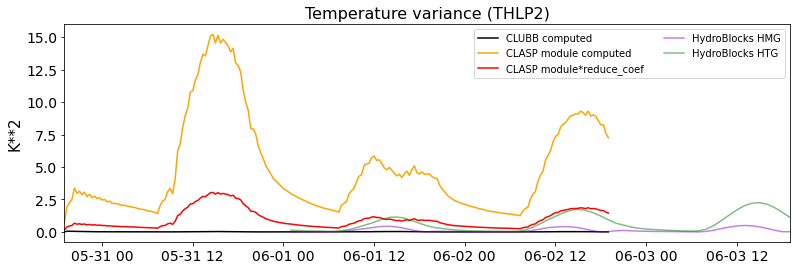

In [8]:
fig,axs = plt.subplots(1,1, figsize=(13,4))

axs.plot(times_local, np.squeeze(camDS['THLP2_CLUBB'].values)[:,-1],'k', label='CLUBB computed')
axs.plot(times_local, np.squeeze(clmDS['THLP2_CLUBB'].values),color='orange', label='CLASP module computed')
axs.plot(times_local, np.squeeze(clmDS['THLP2_CLUBB'].values*reduce_coef),color='red', label='CLASP module*reduce_coef')
axs.plot(timesNate_local, nateHMG.thlp2.values,color='darkviolet', label='HydroBlocks HMG', alpha=0.5)
axs.plot(timesNate_local, nateHTG.thlp2.values,'green', label='HydroBlocks HTG', alpha=0.5)

axs.legend(ncol=2)
axs.set_xlim(datetime.date(2015,5,31),datetime.date(2015,6,4))
#axs.set_xlim(datetime.date(2015,6,4),datetime.date(2015,6,6))
#axs.set_ylim([0,2])

axs.set_ylabel('K**2',fontsize=15)
axs.set_title('Temperature variance (THLP2)', fontsize=16)

axs.tick_params(axis='both', which='major', labelsize=14)


In [9]:
print('Mean THLP2 in CLUBB:                          %.3f' % np.nanmean(np.squeeze(camDS['THLP2_CLUBB'].values)[:,-1]) )
print('Mean THLP2 in CLASP module (w/ reduce coef):  %.3f' % np.nanmean(np.squeeze(clmDS['THLP2_CLUBB'].values*reduce_coef)) )
print('Mean THLP2 in CLASP module (w/o reduce coef): %.3f' % np.nanmean(np.squeeze(clmDS['THLP2_CLUBB'].values)) )

print('Mean THLP2 in HydroBlocks HMG: %.3f' % np.nanmean(nateHMG.thlp2.values) )
print('Mean THLP2 in HydroBlocks HTG: %.3f' % np.nanmean(nateHTG.thlp2.values) )


Mean THLP2 in CLUBB:                          0.011
Mean THLP2 in CLASP module (w/ reduce coef):  0.975
Mean THLP2 in CLASP module (w/o reduce coef): 4.873
Mean THLP2 in HydroBlocks HMG: 0.125
Mean THLP2 in HydroBlocks HTG: 0.941


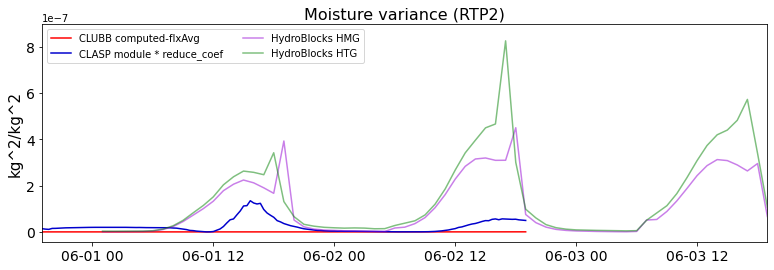

In [10]:
fig,axs = plt.subplots(1,1, figsize=(13,4))

axs.plot(times_local, np.squeeze(camDS['RTP2_CLUBB'].values*1e-6)[:,-1],'red', label='CLUBB computed-flxAvg')
axs.plot(times_local, np.squeeze(clmDS['QP2_CLUBB'].values*reduce_coef),color='mediumblue', label='CLASP module * reduce_coef')

axs.plot(timesNate_local, nateHMG.qp2.values,color='darkviolet', label='HydroBlocks HMG', alpha=0.5)
axs.plot(timesNate_local, nateHTG.qp2.values,'green', label='HydroBlocks HTG', alpha=0.5)

axs.legend(ncol=2)
axs.set_xlim(datetime.date(2015,6,1),datetime.date(2015,6,4))
#axs.set_xlim(datetime.date(2015,6,4),datetime.date(2015,6,6))
#axs.set_ylim([0,1])

axs.set_ylabel('kg^2/kg^2',fontsize=15)
axs.set_title('Moisture variance (RTP2)', fontsize=16)

axs.tick_params(axis='both', which='major', labelsize=14)



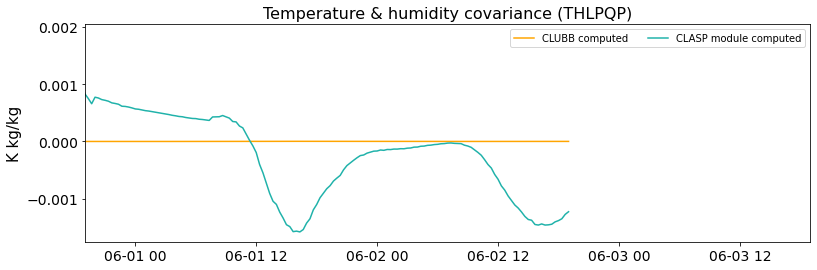

In [11]:
fig,axs = plt.subplots(1,1, figsize=(13,4))

axs.plot(times_local, np.squeeze(camDS['RTPTHLP_CLUBB'].values*(1e-3))[:,-1],'orange', label='CLUBB computed')
axs.plot(times_local, np.squeeze(clmDS['THLPQP_CLUBB'].values),color='lightseagreen', label='CLASP module computed')

# axs.plot(timesNate_local, nateHMG.thlpqp.values,color='darkviolet', label='HydroBlocks HMG', alpha=0.5)
# axs.plot(timesNate_local, nateHTG.thlpqp.values,'green', label='HydroBlocks HTG', alpha=0.5)

axs.legend(ncol=2)
axs.set_xlim(datetime.date(2015,6,1),datetime.date(2015,6,4))
#axs.set_xlim(datetime.date(2015,6,5),datetime.date(2015,6,9))
#axs.set_ylim([0,1])

axs.set_ylabel('K kg/kg',fontsize=15)
axs.set_title('Temperature & humidity covariance (THLPQP)', fontsize=16)

axs.tick_params(axis='both', which='major', labelsize=14)



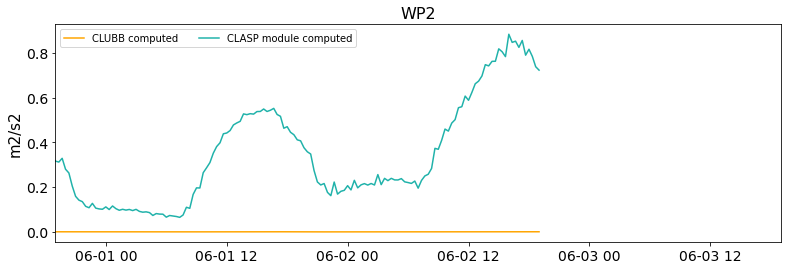

In [12]:
fig,axs = plt.subplots(1,1, figsize=(13,4))

axs.plot(times_local, np.squeeze(camDS['WP2_CLUBB'].values*(1e-3))[:,-1],'orange', label='CLUBB computed')
axs.plot(times_local, np.squeeze(clmDS['WP2_CLUBB'].values),color='lightseagreen', label='CLASP module computed')

# axs.plot(timesNate_local, nateHMG.thlpqp.values,color='darkviolet', label='HydroBlocks HMG', alpha=0.5)
# axs.plot(timesNate_local, nateHTG.thlpqp.values,'green', label='HydroBlocks HTG', alpha=0.5)

axs.legend(ncol=2)
axs.set_xlim(datetime.date(2015,6,1),datetime.date(2015,6,4))
#axs.set_xlim(datetime.date(2015,6,5),datetime.date(2015,6,9))
#axs.set_ylim([0,1])

axs.set_ylabel('m2/s2',fontsize=15)
axs.set_title('WP2', fontsize=16)

axs.tick_params(axis='both', which='major', labelsize=14)




In [14]:
# Sum of all the urban weights (so yes, this is actually half...): 
# 0.250000000000000+8.333333333333333E-002+8.333333333333333E-002+ 5.833333233992258E-002+2.500000099341074E-002

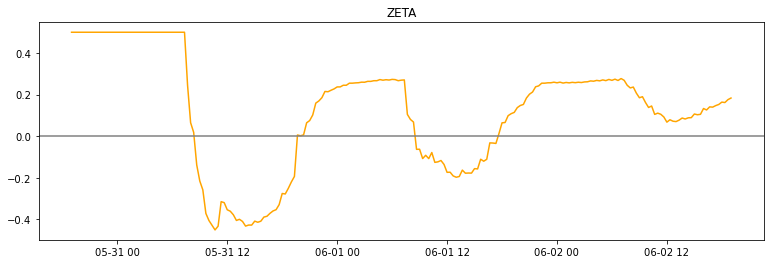

In [13]:
fig,axs = plt.subplots(1,1, figsize=(13,4))
axs.plot(times_local, np.squeeze(clmDS['ZETA'].values),color='orange', label='CLASP module computed')
axs.set_title('ZETA')
axs.axhline(0,color='grey')

Text(0.5, 1.0, 'USTAR')

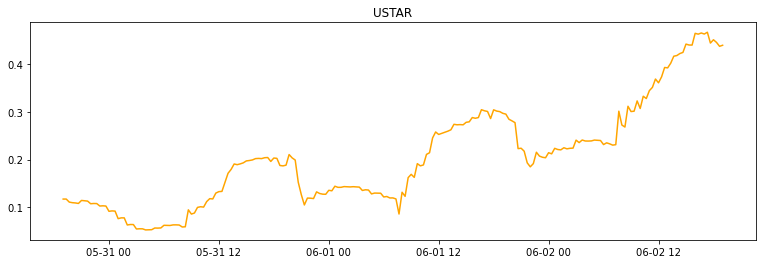

In [15]:
fig,axs = plt.subplots(1,1, figsize=(13,4))
axs.plot(times_local, np.squeeze(clmDS['USTAR'].values),color='orange', label='CLASP module computed')
axs.set_title('USTAR')

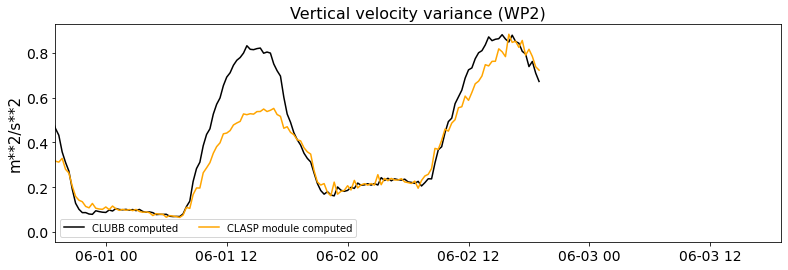

In [14]:
fig,axs = plt.subplots(1,1, figsize=(13,4))

axs.plot(times_local, np.squeeze(camDS['WP2_CLUBB'].values)[:,-1],'k', label='CLUBB computed')
axs.plot(times_local, np.squeeze(clmDS['WP2_CLUBB'].values),color='orange', label='CLASP module computed')

# axs.plot(timesNate_local, nateHMG.wp2.values,color='darkviolet', label='HydroBlocks HMG', alpha=0.75)
# axs.plot(timesNate_local, nateHTG.wp2.values,color='green',        label='HydroBlocks HTG', alpha=0.75)

axs.legend(ncol=2)
axs.set_xlim(datetime.date(2015,6,1),datetime.date(2015,6,4))
#axs.set_xlim(datetime.date(2015,6,4),datetime.date(2015,6,6))

axs.set_ylabel('m**2/s**2',fontsize=15)
axs.set_title('Vertical velocity variance (WP2)', fontsize=16)

axs.tick_params(axis='both', which='major', labelsize=14)



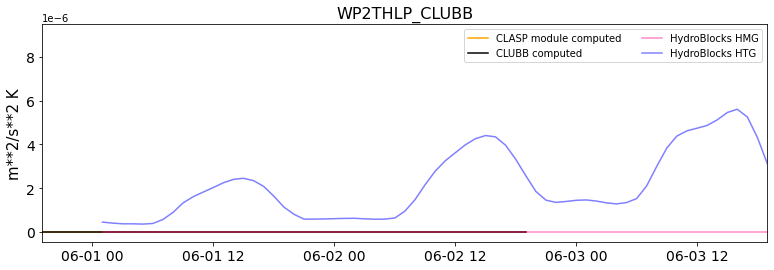

In [16]:
fig,axs = plt.subplots(1,1, figsize=(13,4))

axs.plot(times_local, np.squeeze(clmDS['WP2THLP_CLUBB'].values),color='orange', label='CLASP module computed')
axs.plot(times_local, np.squeeze(camDS['WP2THLP_CLUBB'].values)[:,-1],'k', label='CLUBB computed')

axs.plot(timesNate_local, nateHMG.wp2thetap.values,color='deeppink', label='HydroBlocks HMG', alpha=0.5)
axs.plot(timesNate_local, nateHTG.wp2thetap.values,'b', label='HydroBlocks HTG', alpha=0.5)

axs.legend(ncol=2)
axs.set_xlim(datetime.date(2015,6,1),datetime.date(2015,6,4))
#axs.set_xlim(datetime.date(2015,6,4),datetime.date(2015,6,6))

axs.set_ylabel('m**2/s**2 K',fontsize=15)
axs.set_title('WP2THLP_CLUBB', fontsize=16)

axs.tick_params(axis='both', which='major', labelsize=14)



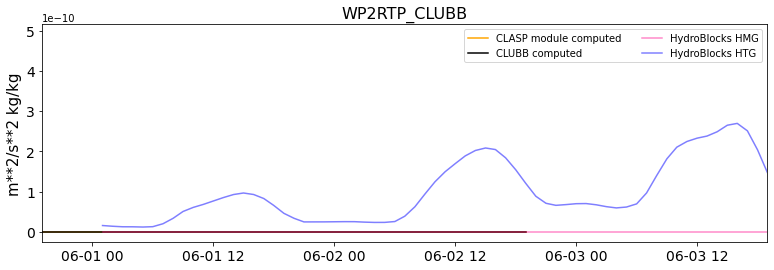

In [17]:
fig,axs = plt.subplots(1,1, figsize=(13,4))

axs.plot(times_local, np.squeeze(clmDS['WP2QP_CLUBB'].values),color='orange', label='CLASP module computed')
axs.plot(times_local, np.squeeze(camDS['WP2RTP_CLUBB'].values)[:,-1],'k', label='CLUBB computed')

axs.plot(timesNate_local, nateHMG.wp2qp.values,color='deeppink', label='HydroBlocks HMG', alpha=0.5)
axs.plot(timesNate_local, nateHTG.wp2qp.values,'b', label='HydroBlocks HTG', alpha=0.5)

axs.legend(ncol=2)
axs.set_xlim(datetime.date(2015,6,1),datetime.date(2015,6,4))
#axs.set_xlim(datetime.date(2015,6,4),datetime.date(2015,6,6))

axs.set_ylabel('m**2/s**2 kg/kg',fontsize=15)
axs.set_title('WP2RTP_CLUBB', fontsize=16)

axs.tick_params(axis='both', which='major', labelsize=14)




## Combine clubb moments into a new HTG forcing file

In [18]:
# Read in old forcing file: 
nateHTG_file = '~/Documents/Analysis/CLASP/NateForcing/clasp-htg.bdate.nc'
nateHTG_orig = xr.open_dataset(nateHTG_file, decode_times=True,engine='netcdf4')

# Times to use... 
iTime   = np.where( (nateHTG_orig.time.values>=clmDS.time.values[0]) & 
          (nateHTG_orig.time.values<=clmDS.time.values[-1]) )[0]

nateHTG_orig = nateHTG_orig.isel(time=iTime)


One issue: Nate's forcing is hourly; time step level output from CLM is every 20 minutes. So two obvious options are to either interpolate the forcing down to 20 minute levels, or to average the CLUBB moments up to hourly. For the first pass, I'll do the latter.

In [19]:
# Get hourly mean CLM values (includes CLUBB output)
#   Gets assigned to hour the average *starts*
hourlyCLM = clmDS.resample(time='1H').mean()


Now we can merge the moments computed in CLM into a new hybrid file that uses the atmospheric fields from HMG but the moments from the CLASP module in CTSM. Just need to ensure units match up.

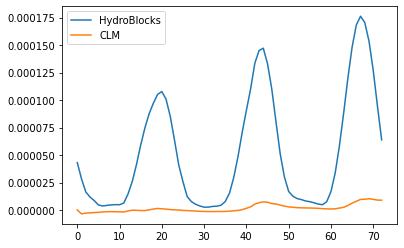

In [20]:
# Look at plot comparisons
plt.plot(np.squeeze(nateHTG_orig.wpqtp_sfc.values))
plt.plot(np.squeeze(hourlyCLM.WPQP_CLUBB.values))
plt.legend(['HydroBlocks','CLM'])


In [21]:
# WPQTP_CLUBB: 
#   kg/kg m/s in Nate's file 
#   same in CLM output
nateHTG_orig['wpqtp_sfc'].values = hourlyCLM.WPQP_CLUBB.values 


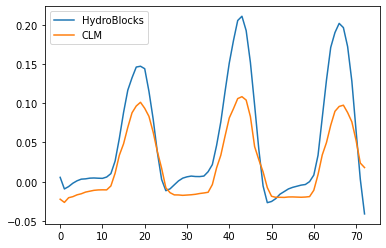

In [22]:
plt.plot(np.squeeze(nateHTG_orig.wpthlp_sfc.values))
plt.plot(np.squeeze(hourlyCLM.WPTHLP_CLUBB.values))
plt.legend(['HydroBlocks','CLM'])

In [23]:
# WPTHLP_CLUBB
#  (kg/kg m/s) in Nate's file
#  Same in CLM output
nateHTG_orig['wpthlp_sfc'].values = hourlyCLM.WPTHLP_CLUBB.values 


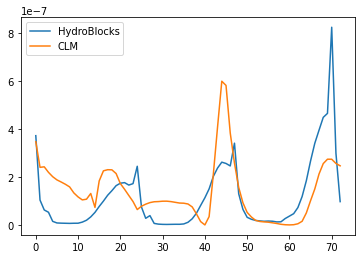

In [24]:
plt.plot(np.squeeze(nateHTG_orig.qp2.values))
plt.plot(np.squeeze(hourlyCLM.QP2_CLUBB.values))
plt.legend(['HydroBlocks','CLM'])

In [25]:
# QP2_CLUBB
#  (kg2/kg2) in Nate's file
#  Same in CLM output
nateHTG_orig['qp2'].values = hourlyCLM.QP2_CLUBB.values 


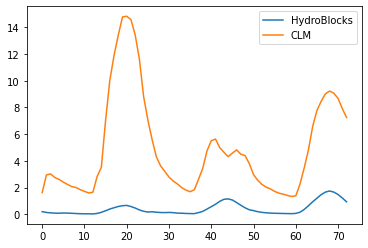

In [26]:
plt.plot(np.squeeze(nateHTG_orig.thlp2.values))
plt.plot(np.squeeze(hourlyCLM.THLP2_CLUBB.values))
plt.legend(['HydroBlocks','CLM'])

In [27]:
# THLP2_CLUBB
#   K2 in both 
nateHTG_orig['thlp2'].values = hourlyCLM.THLP2_CLUBB.values 


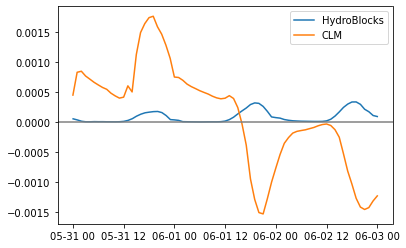

In [28]:
plt.plot(nateHTG_orig['time'],np.squeeze(nateHTG_orig.thlpqp.values))
plt.plot(hourlyCLM['time'],np.squeeze(hourlyCLM.THLPQP_CLUBB.values))
plt.legend(['HydroBlocks','CLM'])
# plt.xlim([datetime.date(2015,6,1), datetime.date(2015,6,7)])
plt.axhline(0,color='gray')

In [29]:
# THLPQP_CLUBB
#  K kg/kg in both
#  ISSUE: looks like almost a sign offset between the CLM computed moments and HydroBlocks
#         Also opposite of what CLUBB computes on its own. 
nateHTG_orig['thlpqp'].values = hourlyCLM.THLPQP_CLUBB.values 



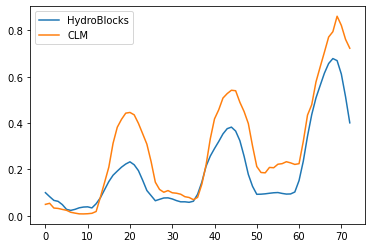

In [30]:
plt.plot(np.squeeze(nateHTG_orig.wp2.values))
plt.plot(np.squeeze(hourlyCLM.WP2_CLUBB.values))
plt.legend(['HydroBlocks','CLM'])

In [31]:
# WP2_CLUBB
#   m2/s2 in both
nateHTG_orig['wp2'].values = hourlyCLM.WP2_CLUBB.values


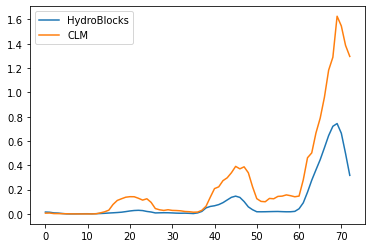

In [32]:
plt.plot(np.squeeze(nateHTG_orig.wp4.values))
plt.plot(np.squeeze(hourlyCLM.WP4_CLUBB.values))
plt.legend(['HydroBlocks','CLM'])

In [33]:
# WP4_CLUBB
#  m4/s4 in both
nateHTG_orig['wp4'].values = hourlyCLM.WP4_CLUBB.values


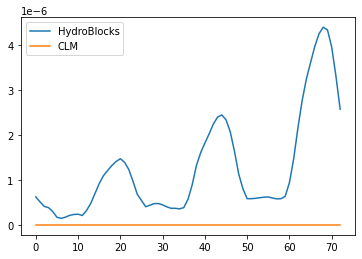

In [34]:
plt.plot(np.squeeze(nateHTG_orig.wp2thetap.values))
plt.plot(np.squeeze(hourlyCLM.WP2THLP_CLUBB.values))
plt.legend(['HydroBlocks','CLM'])


In [35]:
# WP2THP_CLUBB
# K m2/s2 in both 
nateHTG_orig['wp2thetap'].values = hourlyCLM.WP2THLP_CLUBB.values


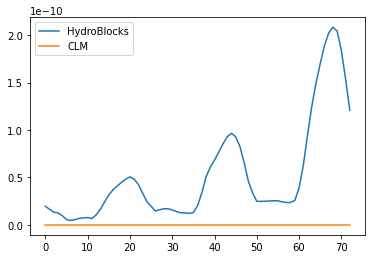

In [36]:
plt.plot(np.squeeze(nateHTG_orig.wp2qp.values))
plt.plot(np.squeeze(hourlyCLM.WP2QP_CLUBB.values))
plt.legend(['HydroBlocks','CLM'])


In [37]:
# WP2QP_CLUBB
# kg/kg m2/s2 in both 
nateHTG_orig['wp2qp'].values = hourlyCLM.WP2QP_CLUBB.values


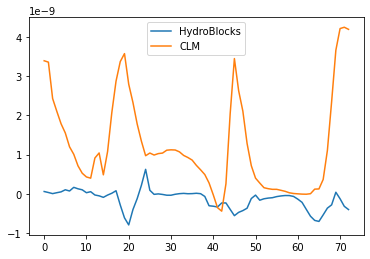

In [38]:
plt.plot(np.squeeze(nateHTG_orig.wpqp2.values))
plt.plot(np.squeeze(hourlyCLM.WPQP2_CLUBB.values))
plt.legend(['HydroBlocks','CLM'])


In [39]:
# WP2QP_CLUBB
#  kg/kg m2/s2 in both 
nateHTG_orig['wpqp2'].values = hourlyCLM.WPQP2_CLUBB.values


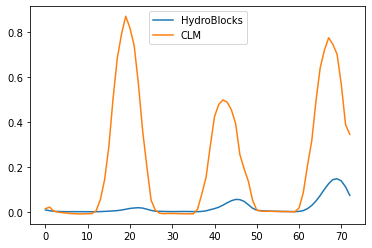

In [40]:
plt.plot(np.squeeze(nateHTG_orig.wpthetap2.values))
plt.plot(np.squeeze(hourlyCLM.WPTHLP2_CLUBB.values))
plt.legend(['HydroBlocks','CLM'])


In [41]:
## WPTHLP2_CLUBB
#   K2 m/s?
nateHTG_orig['wpthetap2'].values = hourlyCLM.WPTHLP2_CLUBB.values


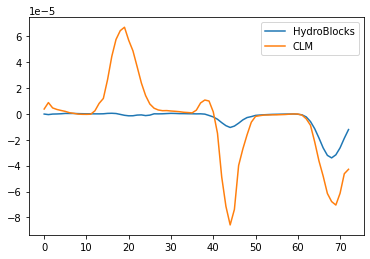

In [42]:
plt.plot(np.squeeze(nateHTG_orig.wpthetapqp.values))
plt.plot(np.squeeze(hourlyCLM.WPTHLPQP_CLUBB.values))
plt.legend(['HydroBlocks','CLM'])

In [43]:
## WPTHLPQP
#   K kg/kg m/s
nateHTG_orig['wpthetapqp'].values = hourlyCLM.WPTHLPQP_CLUBB.values


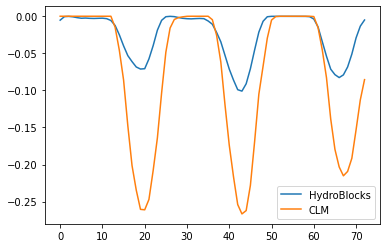

In [44]:
plt.plot(np.squeeze(nateHTG_orig.wp3.values))
plt.plot(np.squeeze(hourlyCLM.WP3_CLUBB.values))
plt.legend(['HydroBlocks','CLM'])



In [45]:
## WP3
#  m3/s3
nateHTG_orig['wp3'].values = hourlyCLM.WP3_CLUBB.values


In [46]:
# Drop upwp and vpwp 
nateHTG_orig = nateHTG_orig.drop_vars('upwp')
nateHTG_orig = nateHTG_orig.drop_vars('vpwp')

In [47]:
# Fudge the numbers a little bit - this would all be easier if the first time were officially 00:00:00 
#   Since we use start_tod = 0 for now. But the first value otherwise is three minutes into the hour 
#   Those three minutes can't matter that much for the data, but do matter for running things...

nateHTG_orig.time.values[0] = np.datetime64('2015-05-31T00:00:00')

# UPDATE: This did not work. Don't know why, but it didn't, so don't bother. 


In [48]:
dataDir

'/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/SingleLandType/zconst_32p5/V2_noSrfPropertiesPrescribed/'

In [49]:
## Now convert to new netCDF file 

#savePath = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/NoMoments-SrfFluxAvg_withCTSMmods/'
fileName = dataDir+'clasp-htgCTSM_IrrOn.SrfFluxAvg.scmIOPlandSrfOff.zconst32p5andre_50urban50lake.nc'

nateHTG_orig.to_netcdf(path=fileName, mode='w',format='NETCDF4_CLASSIC')


In [50]:
len(hourlyCLM.time.values)

73